# Walkability measured with access to sociable places

Replicating 15min City Score for my AOI from:
https://transformtransport.org/research/urban-mobility-metrics/15min-city-score-toolkit-urban-walkability-analytics/

Find the code here:
https://zenodo.org/records/14231427

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects

from shapely.geometry import Point

import os

import networkx as nx
import osmnx as ox
import tobler

In [2]:
print(ox.__version__)
print("Current working directory:", os.getcwd())

1.7.0
Current working directory: /home/dimafra/PycharmProjects/GeospatialProject/notebooks 


## STEP 1. ISOCHRONES GENERATION

* Reading the shapefile of the area of interest;
* Dissolve the shapefile of the extent;
* Get the H3 level and the walking speed;
* Generate the H3 cells over the area of interest.












In [3]:
cityname = 'rome, italy'

epsg:4326
1


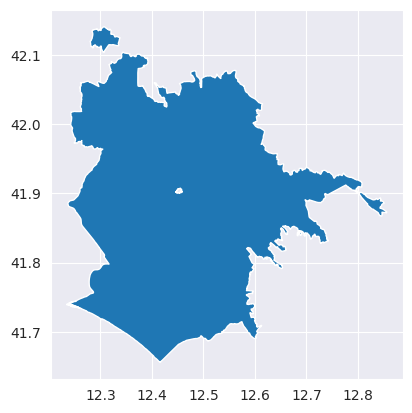

In [4]:
# Modify to match your Area of Interest layer
AOI1  = ox.geocode_to_gdf(cityname)
AOI1.plot()
print(AOI1.crs)
print(AOI1.geometry.count())

We are sure is the right one, it is in EPSG:4326 and has only one geometry.

EPSG:25833


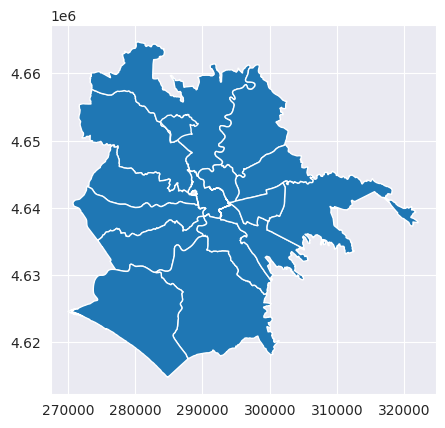

In [5]:
# Loading municipi_final from connectivity_d in data folder (be sure you saved it in the right folder while running connectivity.ipynb)
AOIM = gpd.read_file("../data/connectivity_d/municipi_final.gpkg")
AOIM.plot()
print(AOIM.crs)

In [6]:
print('The input shape file had ', AOI1.geometry.count(), 'polygons at the begininning')
## Ensure that the extent is a single polygon
if AOI1.geometry.count() ==1:
  AOI1 = AOI1
else:
  AOI1 = AOI1.dissolve(by=None)

AOI2 = AOI1
resolution = None
if resolution is None:
  resolution = 9

AOI = tobler.util.h3fy(AOI1, resolution=resolution, clip=False, return_geoms=True) # clip = F generates hexagons out of the borders 
AOI.reset_index(inplace=True)## Remember to not use the hex_id as an index

AOI['Side_length'] = AOI.to_crs(25833).length/6
len(AOI.hex_id.unique())

print('and now it is just', AOI1.geometry.count(), 'polygon')

The input shape file had  1 polygons at the begininning
and now it is just 1 polygon


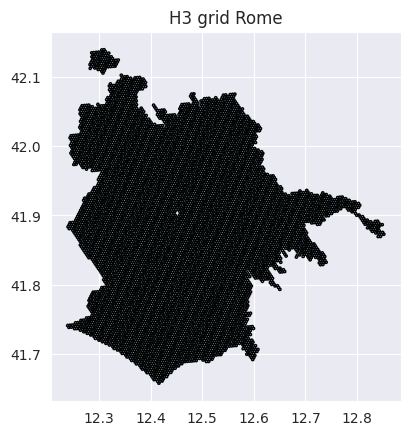

In [7]:
AOI.plot(edgecolor='k', facecolor='lightblue')
plt.title("H3 grid Rome")
plt.show()

Apart from vatican city the grid is not presenting holes.

*  Configure the network parameters;
*  Extract the H3 cells centroids;
*  Extract the walking network from OSM;
*  Reproject the centroids and the OSM pedestrian network;
*  Estimate walking time by adding 'time' attribute to the edges of the pedestrian network.










In [8]:
travel_speed = 4.5 # walking speed [km/hour]
if travel_speed is None:
  print('the walking speed could not be empty')

In [9]:
# Extracting the cells centroids in 25833 cause using 4326 leads to imprecise results.
AOI = AOI.to_crs(epsg=25833)
AOI['centroid'] = AOI.centroid

In [11]:
# Centroids gdf 
CT = AOI.drop('geometry', axis='columns', inplace=False)
CT['geometry'] = CT['centroid']
CT.set_crs(25833, inplace=True)  

# Loading pedestrian network (be sure you saved it in the right folder while running connectivity.ipynb)
G = ox.load_graphml("../data/connectivity_d/graph_simplified.graphml")
#G = ox.load_graphml("../data/connectivity_d/graph_original.graphml")

# Ensuring the walking network is in the same shape of centroids
crs = G.graph.get('crs', None)
print("graph CRS:", crs)

if crs != 'EPSG:28533':
    G_proj = ox.projection.project_graph(G, to_crs=25833)
else:
    G_proj = G

# Add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to meter per minute
for _, _, _, data in G_proj.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

graph CRS: EPSG:25833


* Extract the network nearest points to the cell centroids (this links the centroids with the network).
* Ensure the nearest points to centroid is within the hexagon cell.


In [12]:
'''
In order to work properly, in nearest_nodes, CT and G_proj must be in the same CRS.
'''

# Extract the centroids coordinates and assigned the network nearest node to each centroid
coords = np.array([geom.xy for geom in CT['geometry'] if geom is not None])

# Extract the centorids IDs
ids1 = np.array([idx for geom, idx in zip(CT['geometry'], CT['hex_id']) if geom is not None])

coords = coords.reshape(-1, 2)

# Calculate the nearest nodes for all coordinates at once
nearest_nodes, distances = ox.distance.nearest_nodes(G_proj, coords[:, 0], coords[:, 1], return_dist=True)

# Create the center_node list considering the 'side_length'
center_node1 = []

for nearest_node, hex_id, distance, side_length in zip(nearest_nodes, ids1, distances, CT['Side_length']):
    if distance <= side_length:
        center_node1.append((nearest_node, hex_id))

In [13]:
# Create a GeoDataFrame for the center nodes
center_nodes_gdf = gpd.GeoDataFrame(geometry=[Point(G_proj.nodes[point]['x'], G_proj.nodes[point]['y']) for point, hex_id in center_node1],
                                    index=[hex_id for point, hex_id in center_node1],
                                    columns=['geometry'], crs=25833)

# Ensure AOI is in the same crs of intersected_nodes for spatial join
intersected_nodes = AOI.sjoin(center_nodes_gdf)
intersected_hex_ids = set(intersected_nodes['hex_id'])

# Filter center_node1 to keep only tuples with hex_id in intersected_hex_ids
filtered_center_node1 = [(node, hex_id) for node, hex_id in center_node1 if hex_id in intersected_hex_ids]

In [14]:
print("CRS di AOI:", AOI.crs)
print("CRS di center_nodes_gdf:", center_nodes_gdf.crs)

CRS di AOI: EPSG:25833
CRS di center_nodes_gdf: EPSG:25833


## !!! Instead of running the following cells in order to test this specific example go directly to step 3 where isochrones and amenities are loaded in order to save time for testing 

*   Here we generate 15 isochrones from each nearest points to the cell centroids (each centroid represents 1 minute of walking distance);
*   The generation process was optimized by using the convex hull as a polygon representation of the generated isochrones.




In [12]:
#This is the most computational intensive part, as it calculates the isochrones and the related processes.

# Create a graph from the center nodes
isochrone_polys = []

trip_time = 0
while trip_time <16:
  isochrone_poly = []  # Initialize isochrone_poly for each trip_time
  for node, node_id in center_node1:
        subgraph = nx.ego_graph(G_proj, node, radius=trip_time, distance="time")
        node_points = [Point(data["x"], data["y"]) for _, data in subgraph.nodes(data=True)]
        bounding_poly = gpd.GeoSeries(node_points).union_all().convex_hull
        bounding_gdf = gpd.GeoDataFrame(geometry=[bounding_poly])
        bounding_gdf['time_in_min'] = trip_time
        bounding_gdf['grid_id'] = node_id  # Add the node ID as an attribute
        isochrone_poly.append(bounding_gdf)
  isochrone_polys.append(isochrone_poly)
  trip_time += 1


#to combine them all into a single GeoDataFrame:
gdf = gpd.GeoDataFrame(pd.concat([pd.concat(isochrone_poly) for isochrone_poly in isochrone_polys], ignore_index=True))
#remove the existing LINESTRING & POINTS from the isochrones
minute_walk  = meters_per_minute


isochrone_line = gdf[gdf.geometry.type=='LineString']
isochrone_line = isochrone_line.copy()
isochrone_line['geometry'] = isochrone_line.buffer(minute_walk).geometry


isochrone_points = gdf[gdf.geometry.type=='Point']
isochrone_points = isochrone_points.copy()
isochrone_points['geometry'] = isochrone_points.buffer(minute_walk).geometry


gdf = gdf[gdf.geometry.type!='LineString']
gdf = gdf[gdf.geometry.type!='Point']

gdf = gpd.GeoDataFrame(pd.concat([gdf, isochrone_points, isochrone_line], ignore_index=True))

In [14]:
#optionally, save the generated isochrones into a directory
#gdf = gdf.set_crs("EPSG:25833")
#gdf.to_file("../data/15min_d/isochrones2.gpkg") ## add your directory

## STEP 2. DOWNLOADING OSM DATA

**The procedure is as the following, the user will specify the categories they are interested in out of the main 8 propposed ones.**

**The chosen categories by the user will be stored in one GeoDataFrame having the columns 'category' and 'macro_service' indicating to which categories and what is the macro categories the amenity belongs to.**


**The GeoDataFrame would be used the in the 3rd phase (intersection).**

*   The 15min City Score Toolkit grouped the identifyied needed proximity services into main 8 categories namely neighborhood services, healthcare, neighbothood shops, education, sports, cultural entertainment, open leisure and mobility.

*  In the following cell, we used the OSM terminology to identify and group the needed proximities.





In [15]:
############# Neighborhood services #############################
post_offices = {'amenity': ['post_office']}
financial = {'amenity': ['bank', 'atm']}

office = {'office': ['cleaning', 'gardener', 'computer']}, #still proposals, saved for future
squares = {'place': 'square'}

comunity_centre = {'amenity': ['community_centre', 'social_facility', 'social_centre']}
police = {'amenity': ['fire_station', 'police']}  # refers to Police offices and firefight office
place_of_worship = {'amenity': ['place_of_worship']}
water = {'amenity': ['drinking_water', 'water_point','watering_place']} #* CONFLICT IN 'FOUNTAIN'
bar = {'amenity': ['bar']}
cafes = {'amenity': ['cafe', 'ice_cream']}
administration_offices = {'amenity': ['townhall']} # refers to the Local public administration offices
personal_services = {'amenity': ['cafe', 'ice_cream']}
tobacconists_newsagents = {'shop': ['tobacco', 'kioks', 'newsagent']}


Neighborhood_services = {
    'Post_offices': post_offices,
    'Financial': financial,
    'Squares': squares,
    'Comunity_centre': comunity_centre,
    'Police': police,
    'Place_of_worship': place_of_worship,
    'Water': water,
    'Bar': bar,
    'Cafes': cafes,
    'Administration_offices': administration_offices,
    'Personal_services': personal_services,
    'Tobacconists_newsagents': tobacconists_newsagents
}

############## Healthcare #############################
Hospitals = {'amenity': ['hospital']}
Pharmacies = {'amenity': ['pharmacy']}
clinics = {'amenity': ['clinic']}  # refers to the public/private clinics
health_services = {'amenity': ['dentist', 'veterinary', 'doctor']}  # refers to local health services
First_aid = {'emergency':True} # while the time of developing this tool, this tag ('amenity': 'first_aid') is just a proposal

Healthcare = {
    'Hospitals': Hospitals,
    'Pharmacies': Pharmacies,
    'Clinics': clinics,
    'Local Health Services': health_services,
    'First aid': First_aid
}


############# Neighbourhood shops #############################
grocery = {'shop':['grocery','supermarket','convenience','greengrocer','butcher','dairy','bakery']}
retail = {'shop':['general', 'variety_store'], 'amenity': ['vending_machine']}
book_shop = {'shop':['books'], 'amenity':['Toy_library']}
local_markets = {'amenity': ['marketplace']}
restaurants = {'amenity': ['restaurant', 'fast_food', 'food_court']}
supermarkets = {'shop': ['supermarket']}
non_food = {'shop': ['electronics', 'clothes', 'shoes']} # refer to the local non-food shops




Neighbourhood_shops = {
    'Grocery': grocery,
    'Retail': retail,
    'Bookshops': book_shop,
    'Local markets': local_markets,
    'Restaurants': restaurants,
    'Supermarkets': supermarkets,
    'local non-food shops': non_food

}


############# Education #############################
Kindergarten = {'amenity':['Kindergarten', 'childcare']}
school = {'amenity':['school']}
universities = {'amenity':['university', 'college', 'reseach_institute']}
professional_school = {'amenity':['music_school', 'language_school', 'first_aid_school', 'training', 'driving_school', 'dancing_school']}
libraries = {'amenity':['library', 'public_bookcase']}



Education = {
    'Kindergartens': Kindergarten,
    'Schools': school,
    'Universities': universities,
    'Professional schools': professional_school,
    'Libraries': libraries
}





############# Sports #############################
Gym = {'leisure':['fitness_centre', 'fitness_station'], 'sport':'gymnastics'}
Sport_facilities = {'leisure':['sports_centre', 'sports_hall'], 'training':'sport', 'sport':'swimming',}# 'amenity':'sport_school' >> deprecated features

Sports_shops = {
    #'Leisure': Leisure1,
    'Gym': Gym,
    'Sport Facilities': Sport_facilities
}


############# Cultural & entertainment #############################
Cinema = {'amenity':'cinema'}
Theatre = {'amenity':'theatre'}
Museum = {'amenity':'arts_centre','tourism':'museum'}


Cultural = {
    'Cinema': Cinema,
    'Theatre': Theatre,
    'Museum': Museum
}


############# Open Leisure #############################
Parks = {'leisure':['park'], 'amenity': 'bbq'}
kids_playgrounds = {'leisure':['playground']}
dog_parks = {'leisure':['dog_park']}
Gardens = {'leisure':['garden']}


Open_Leisure = {
    'Parks': Parks,
    'Kids playgrounds': kids_playgrounds,
    'Dog parks': dog_parks,
    'Gardens': Gardens
}



############# Mobility #############################
PT_on_surface_stop = {'railway': ['tram_stop'],'highway':'bus_stop'}
bike_parking = {'amenity': ['bicycle_parking', 'bicycle_rental']}
sharing = {'amenity': ['car_sharing' ,'taxi']}
Metro = {'railway': 'subway_entrance'}
stations = {'railway':['station', 'halt']} # , 'railway':'station'


Mobility = {
    'PT_osurface_stop': PT_on_surface_stop,
    'Bike parking': bike_parking,
    'Bike_carsharing': sharing,
    'Metro': Metro,
    'Rail stations': stations
}

*   We used the  [OSMnx](https://osmnx.readthedocs.io/en/stable/) *features_from_bbox* function to extract the identified proximity services from OSM.
*   The extracted services were then arranged in *category, macro_service* form.



In [16]:
##extract the amenities from OSM, ordering amenities in categories
AOI = AOI.to_crs(4326)
north, south, east, west = AOI.total_bounds[3], AOI.total_bounds[1], AOI.total_bounds[2], AOI.total_bounds[0]

def get_category_data(north, south, east, west, category_dict, category_name):
    category_shp_list = []

    for name, sub_category in category_dict.items():
      try:
        category_shp = ox.features.features_from_bbox(north, south, east, west, sub_category)
        category_shp['macro_service'] = name  # Add a new column for macro_service
        category_shp['category'] = category_name  # Add a new column for category name
        category_shp_list.append(category_shp)
      except ox._errors.InsufficientResponseError:
        print(f"No data for category {name}, skipping.")

    if not category_shp_list:
      return None

    # Combine the individual GeoDataFrames
    combined_geo = pd.concat(category_shp_list, ignore_index=True)

    # Define the columns to keep
    columns_to_keep = ['geometry', 'macro_service', 'category']

    # Create a new GeoDataFrame with the specified columns
    category_shapefile = combined_geo[columns_to_keep]

    return category_shapefile


categories = None


categories = [("Neighborhood_services",Neighborhood_services),  ("Healthcare", Healthcare), ("Neighbourhood_shops", Neighbourhood_shops), ("Education", Education), ("Sports_shops", Sports_shops), ("Cultural", Cultural), ("Open_Leisure", Open_Leisure), ("Mobility", Mobility)]
if categories is None:
  print ('you should choose at least one category')

OSM_data = gpd.GeoDataFrame()
# category_scaling is useful to understand the number of downloaded macro_services within each category in this city
# we'll use this later to scale the number of the OSM data @ each category
category_scaling = {}
for category_name, category_dict in categories:
    category_shape = get_category_data(north, south, east, west, category_dict, category_name)
    if category_shape is not None:
      OSM_data = pd.concat([OSM_data, category_shape], ignore_index=True)
      category_scaling[category_name] = len(category_shape['macro_service'].unique())


Performing further cleaning to the proximity data by clipping into the AOI, reproject the services points. Taking the centroids of the Polygons and lines.

In [17]:
print(AOI.crs)
print(OSM_data.crs)

EPSG:4326
epsg:4326


In [18]:
# For clip() ensure OSM_data and AOI have same crs
OSM_data = OSM_data.clip(AOI)
OSM_data = OSM_data.to_crs(25833)


# Filtering the OSM_data geom type: if 1- point: accepted
#                                      2- polygon: centroid and add the generated geometry to the data
#                                      3- line: remove from dataset


#Extract the polygons data from OSM and convert its geometries into Points (centroids of the Polygons)


Polygons_OSM = OSM_data[OSM_data.geometry.type=='Polygon']
Polygons_OSM = Polygons_OSM.copy()
Polygons_OSM['geometry'] = Polygons_OSM.centroid

Multi_Polygons_OSM = OSM_data[OSM_data.geometry.type=='MultiPolygon']
Multi_Polygons_OSM = Multi_Polygons_OSM.copy()
Multi_Polygons_OSM['geometry']  = Multi_Polygons_OSM.centroid

#remove the existing LINESTRING & POLYGONS from OSM_data
OSM_data = OSM_data[OSM_data.geometry.type!='LineString']
OSM_data = OSM_data[OSM_data.geometry.type!='Polygon']
OSM_data = OSM_data[OSM_data.geometry.type!='MultiPolygon']


#Add the centroid Points data to the OSM_data
OSM_data_pts = gpd.GeoDataFrame(pd.concat([OSM_data, Polygons_OSM, Multi_Polygons_OSM], ignore_index=True))

In [19]:
# Save the extracted amenities into your directory.
#OSM_data_pts.to_file("../data/15min_d/amenities2.gpkg") #specify  your directory

## STEP 3. INTERSECT THE ISOCHRONES WITH OSM DATA

**The OSM is joined with the isochrones. For each centroid, the nearest macro services of each category is wieghted inverserly with the distance.--> The score of each category is computed.**

**The sum of the whole categories is computed and then the city-relative cityscore is computed.**


*  Intersecting the Extracted OSM services with the generated isochrones;
*  Weighting the services using a distance decay function.



In [15]:
# Uncomment and load to save time 
#OSM_data_pts = gpd.read_file("../data/15min_d/amenities2.gpkg")
#gdf = gpd.read_file("../data/15min_d/isochrones2.gpkg")

In [16]:
OSM_data_pts['geometry1'] = OSM_data_pts['geometry']
# intersect all
joint_data = gdf.sjoin(OSM_data_pts)

joint_data = joint_data.sort_values(by='time_in_min')

# Group the DataFrame by 'centroid_id' and collect all the 'macro_service' values with the minimum distance
joint_data = joint_data.groupby(['grid_id', 'category']).first().reset_index()


alpha_coeffecient = 0.08

joint_data['weight'] =   1/(joint_data['time_in_min']**alpha_coeffecient)
joint_data.loc[joint_data['time_in_min']==0.0, "weight"] = 1


# Restructure the data
weighted_data = joint_data.pivot(index='grid_id', columns='category', values='weight')

# Replace (NaN) with zeros
weighted_data = weighted_data.fillna(0)

weighted_data = weighted_data.reset_index()

# Rename the columns
weighted_data.columns.name = None

Generate the Diagnostic report contains the *count* and the *percentage* of each category in every hexagon cell.





In [17]:
# Perform spatial join
intersected_ = gpd.sjoin(gdf, OSM_data_pts, how='left', predicate='intersects')

# Group by hexagon and category, and aggregate counts
grouped_data = joint_data.groupby(['grid_id', 'category']).size().reset_index(name='count')

# Calculate total points and percentage
total_points = grouped_data.groupby('grid_id')['count'].sum().reset_index(name='total_count')
grouped_data = grouped_data.merge(total_points, on='grid_id')
grouped_data['percentage'] = (grouped_data['count'] / grouped_data['total_count']) * 100



pivoted_data = grouped_data.pivot_table(index='grid_id', columns='category', values=['count', 'percentage'], fill_value=0)

# Flatten the MultiIndex and add 'count' and '%' to the column names
pivoted_data.columns = [f'{col[1]}_{col[0]}' for col in pivoted_data.columns]

#Generate a dataframe of the diagnostic file, merge it with the AOI and save the results as Geopackage and CSV
diagnostic = pd.DataFrame(pivoted_data)

diagnostic_on_grid = pd.merge(AOI, diagnostic, left_on='hex_id', right_on='grid_id')

diagnostic_on_grid = diagnostic_on_grid.drop(['centroid', 'hex_id', 'Side_length'], 
   axis='columns', inplace=False)
diagnostic_on_grid = diagnostic_on_grid.to_crs(epsg=25833)

diagnostic_on_grid = gpd.GeoDataFrame(diagnostic_on_grid, geometry=diagnostic_on_grid['geometry'])

In [17]:
#Exporting the Diagnostic report
#diagnostic_on_grid.to_file("../data/15min_d/diagnostics.gpkg") #Specify your directory
#diagnostic.to_csv('../data/15min_d/diagnostics.csv')#Specify your directory

*   Indicate the presence / absence of each category services within every hexagon cell;
* Compute the weight of each category services with every hexagon cell.



In [18]:
# Rename columns except the first one
weighted_data = weighted_data.rename(columns=lambda x: x if x == 'grid_id' else f"{x}_weighted")

category_list = {
    'Neighborhood_services': 5,
    'Healthcare': 5,
    'Neighbourhood_shops': 5,
    'Education': 5,
    'Sports_shops': 5,
    'Cultural': 5,
    'Open_Leisure': 5,
    'Mobility': 5
}

for category, scaling_value in category_list.items():
    weighted_column = f"{category}_weighted"
    presence_column = f"{category}_presence"
    
    if weighted_column not in weighted_data.columns:
        # Add the missing weighted column with default value of 0
        weighted_data[weighted_column] = 0
    
    # Create the presence column
    weighted_data[presence_column] = (weighted_data[weighted_column] > 0).astype(int)

weighted_categories_columns = [
    'Neighborhood_services_weighted',
    'Healthcare_weighted',
    'Neighbourhood_shops_weighted',
    'Education_weighted',
    'Sports_shops_weighted',
    'Cultural_weighted',
    'Open_Leisure_weighted',
    'Mobility_weighted'
]

presence_columns = [
    'Neighborhood_services_presence',
    'Healthcare_presence',
    'Neighbourhood_shops_presence',
    'Education_presence',
    'Sports_shops_presence',
    'Cultural_presence',
    'Open_Leisure_presence',
    'Mobility_presence'
]



*  Estimate the initial City Score of each cell as the summation of the weighted services;


*   The coexistence indicate the number category services within 15 mins from the centroid of each hexagon cell (minimum is 0 and maximum is 8);
*  The final 15min City Score values estimated for each hexagon cell as scale stretching of the intial 15min City Score as the following:

     
$$
\text{Final CS} = \frac{\text{inital CS}}{8} \text{    }\ast 100
$$



In [19]:
weighted_data['initial_cityscore'] = weighted_data[weighted_categories_columns].sum(axis=1)

weighted_data['Coexistence'] = weighted_data[presence_columns].sum(axis=1)
# Since the optimum initial score would be 8 in the ideal case, we then could normalize the initial score for grids by 100/8
# then, it would generate values between 0 to 100. However, we would like to make a relative score, so the optimum vlaue (100)
# would given to the highest score withing the area of interest, thus; the score_scaling is introduced here:

highest_initial = 8
lowest_initial = 0  #weighted_data.initial_cityscore.min()
range = highest_initial - lowest_initial

weighted_data['cityscore'] = ((weighted_data['initial_cityscore'] - lowest_initial)/range) * 100

In [20]:
Cityscore_on_grid = pd.merge(AOI, weighted_data, left_on='hex_id', right_on='grid_id')

Cityscore_on_grid = Cityscore_on_grid.drop(['centroid', 'grid_id'],
  axis='columns', inplace=False)

Cityscore_on_grid = Cityscore_on_grid.to_crs(epsg=25833)
Cityscore_on_grid = gpd.GeoDataFrame(Cityscore_on_grid, geometry=Cityscore_on_grid['geometry'])

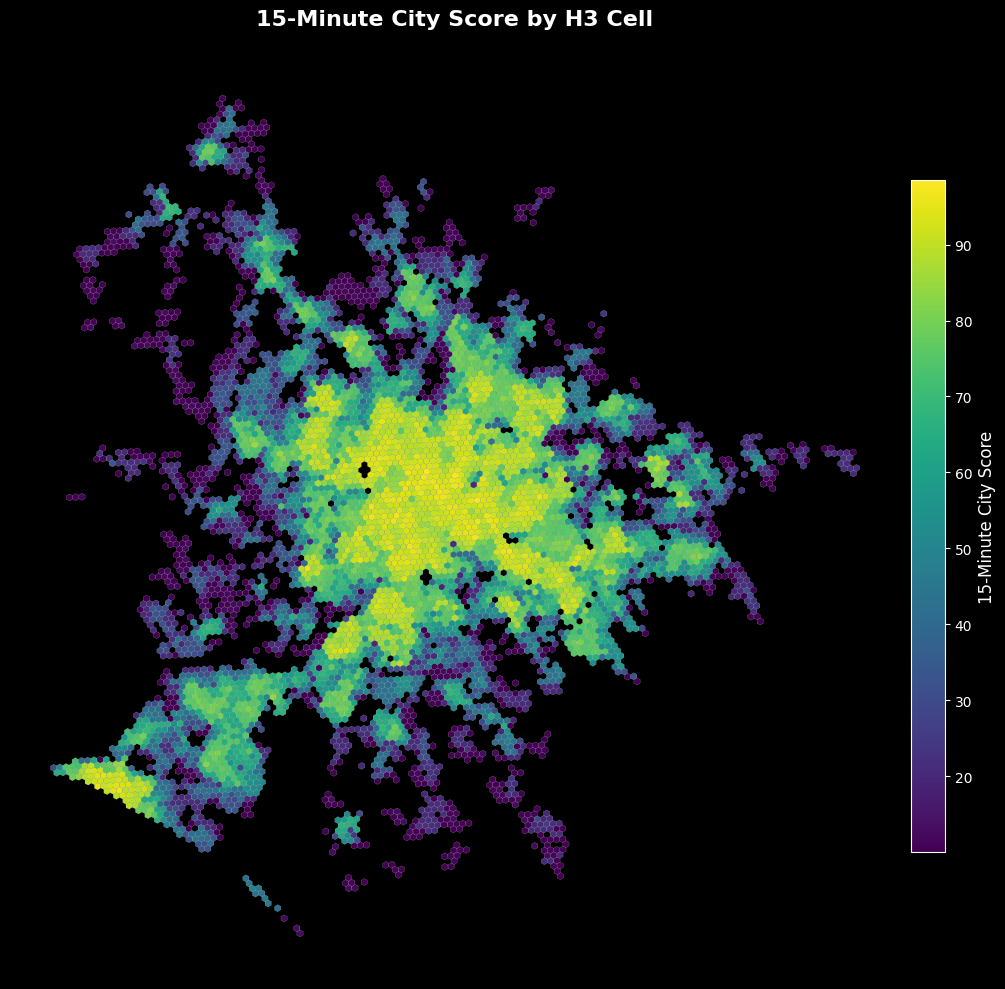

In [58]:
# Normalizing cityscore for colorbar
norm = mcolors.Normalize(
    vmin=Cityscore_on_grid['cityscore'].min(), 
    vmax=Cityscore_on_grid['cityscore'].max()
)
cmap = plt.cm.viridis

# Creaating fig
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Plot H3 cells colored by cityscore
Cityscore_on_grid.plot(
    column="cityscore",
    cmap=cmap,
    linewidth=0.1,
    edgecolor='white',
    ax=ax,
    zorder=2
)

# Removing axis adding title
ax.set_axis_off()
ax.set_title(
    "15-Minute City Score by H3 Cell", 
    fontsize=16, 
    fontweight='bold', 
    pad=20,
    color='white'
)

# Creating personalized colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
cbar.set_label('15-Minute City Score', fontsize=12, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# Layout 
plt.tight_layout()

# Save
#plt.savefig('../output/15min_score.png', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')

plt.show()


## Coverage

The previous plot clearly shows that the hexagons do not fully cover the study area. Let's investigate this further.
 

In [23]:
print("Total number of hex:", len(AOI))
print("Hex having a score:", len(Cityscore_on_grid)) 

Total number of hex: 11413
Hex having a score: 6422


In [24]:
used_hex_ids = set([hex_id for _, hex_id in center_node1])
missing_node_ids = set(AOI['hex_id']) - used_hex_ids
print("Hex missing an associated network's node:", len(missing_node_ids))

Hex missing an associated network's node: 4119


In [25]:
print("Hex having associated node:", len(set([hex_id for _, hex_id in center_node1])))

Hex having associated node: 7294


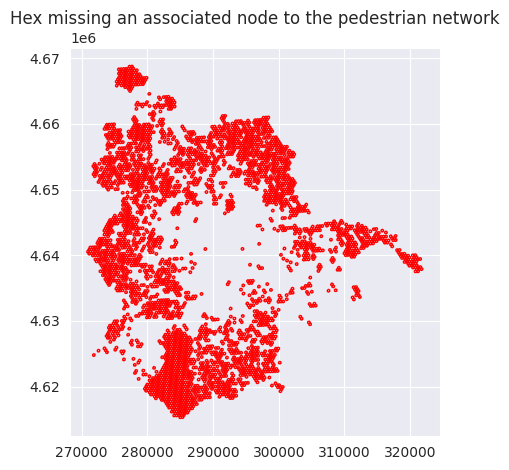

In [37]:
missing_node_gdf = AOI[AOI['hex_id'].isin(missing_node_ids)].to_crs(25833)
missing_node_gdf.plot(edgecolor='red', facecolor='none')
plt.title("Hex missing an associated node to the pedestrian network")


# Tight layout
plt.tight_layout()

# Save
#plt.savefig('../output/hex_missing.png')

In [39]:
missing_ids = set(AOI['hex_id']) - set(Cityscore_on_grid['hex_id'])
print("Missing hex:", len(missing_ids))

Missing hex: 4991


Passing the original not simplified graph ->

4,119 hexagons (≈28%) are not connected to the pedestrian network, so analysis can’t start from there.

872 hexagons are reachable but no services are within accessible distance → score = 0 (still valid).

6,422 hexagons were successfully analyzed.

## Municipalities Classified

To ensure a robust classification of the municipalities, in the next cells it has been calculated the coverage_ratio, which is the fraction of hexagons for which a valid cityscore could be computed. The mean_cityscore represents the average cityscore calculated only on the hexagons with available data. I have then defined a weighted cityscore as:

mean_cityscore_weighted = mean_cityscore×coverage_ratio

In this way, municipalities with high coverage maintain values close to the original scores, while municipalities with low coverage see their cityscore proportionally reduced, reflecting the actual low accessibility. This reduction is justified by two possible reasons: the lack of connected pedestrian infrastructure and the absence of services reachable within 15 minutes.


In [40]:
AOI_C = AOI.to_crs(25833)
AOI_with_mun = gpd.sjoin(AOI_C, AOIM[['geometry', 'name']], how='left', predicate='intersects')

In [41]:
print(len(AOI_with_mun)) # bigger cause intersects creates duplicates 
print(len(AOI))

12497
11413


In [42]:
# No of hex per municipality
total_hex = AOI_with_mun.groupby('name').size().reset_index(name='total_hex')

# hex with score
hex_with_mun = gpd.sjoin(Cityscore_on_grid, AOIM[['geometry', 'name']], how='left', predicate='intersects')
# Now every hex has one column indicating the neighborhood it belongs to.
valid_hex = hex_with_mun.groupby('name').size().reset_index(name='hex_with_score')

# Merge e coverage
coverage = total_hex.merge(valid_hex, on='name', how='left')
coverage['hex_with_score'] = coverage['hex_with_score'].fillna(0)
coverage['coverage_ratio'] = coverage['hex_with_score'] / coverage['total_hex']


In [43]:
score_x_mun = hex_with_mun.groupby('name')['cityscore'].mean().reset_index()

In [44]:
AOIM = AOIM.merge(score_x_mun, on='name', how='left')

In [45]:
AOIM = AOIM.merge(coverage[['name', 'coverage_ratio']], on='name', how='left')

AOIM['cityscore_weighted'] = AOIM['cityscore'] * AOIM['coverage_ratio']

In [46]:
edges_s = gpd.read_file("../data/connectivity_d/edges_s.gpkg")
print(edges_s.crs)
print(AOIM.crs)

EPSG:25833
EPSG:25833


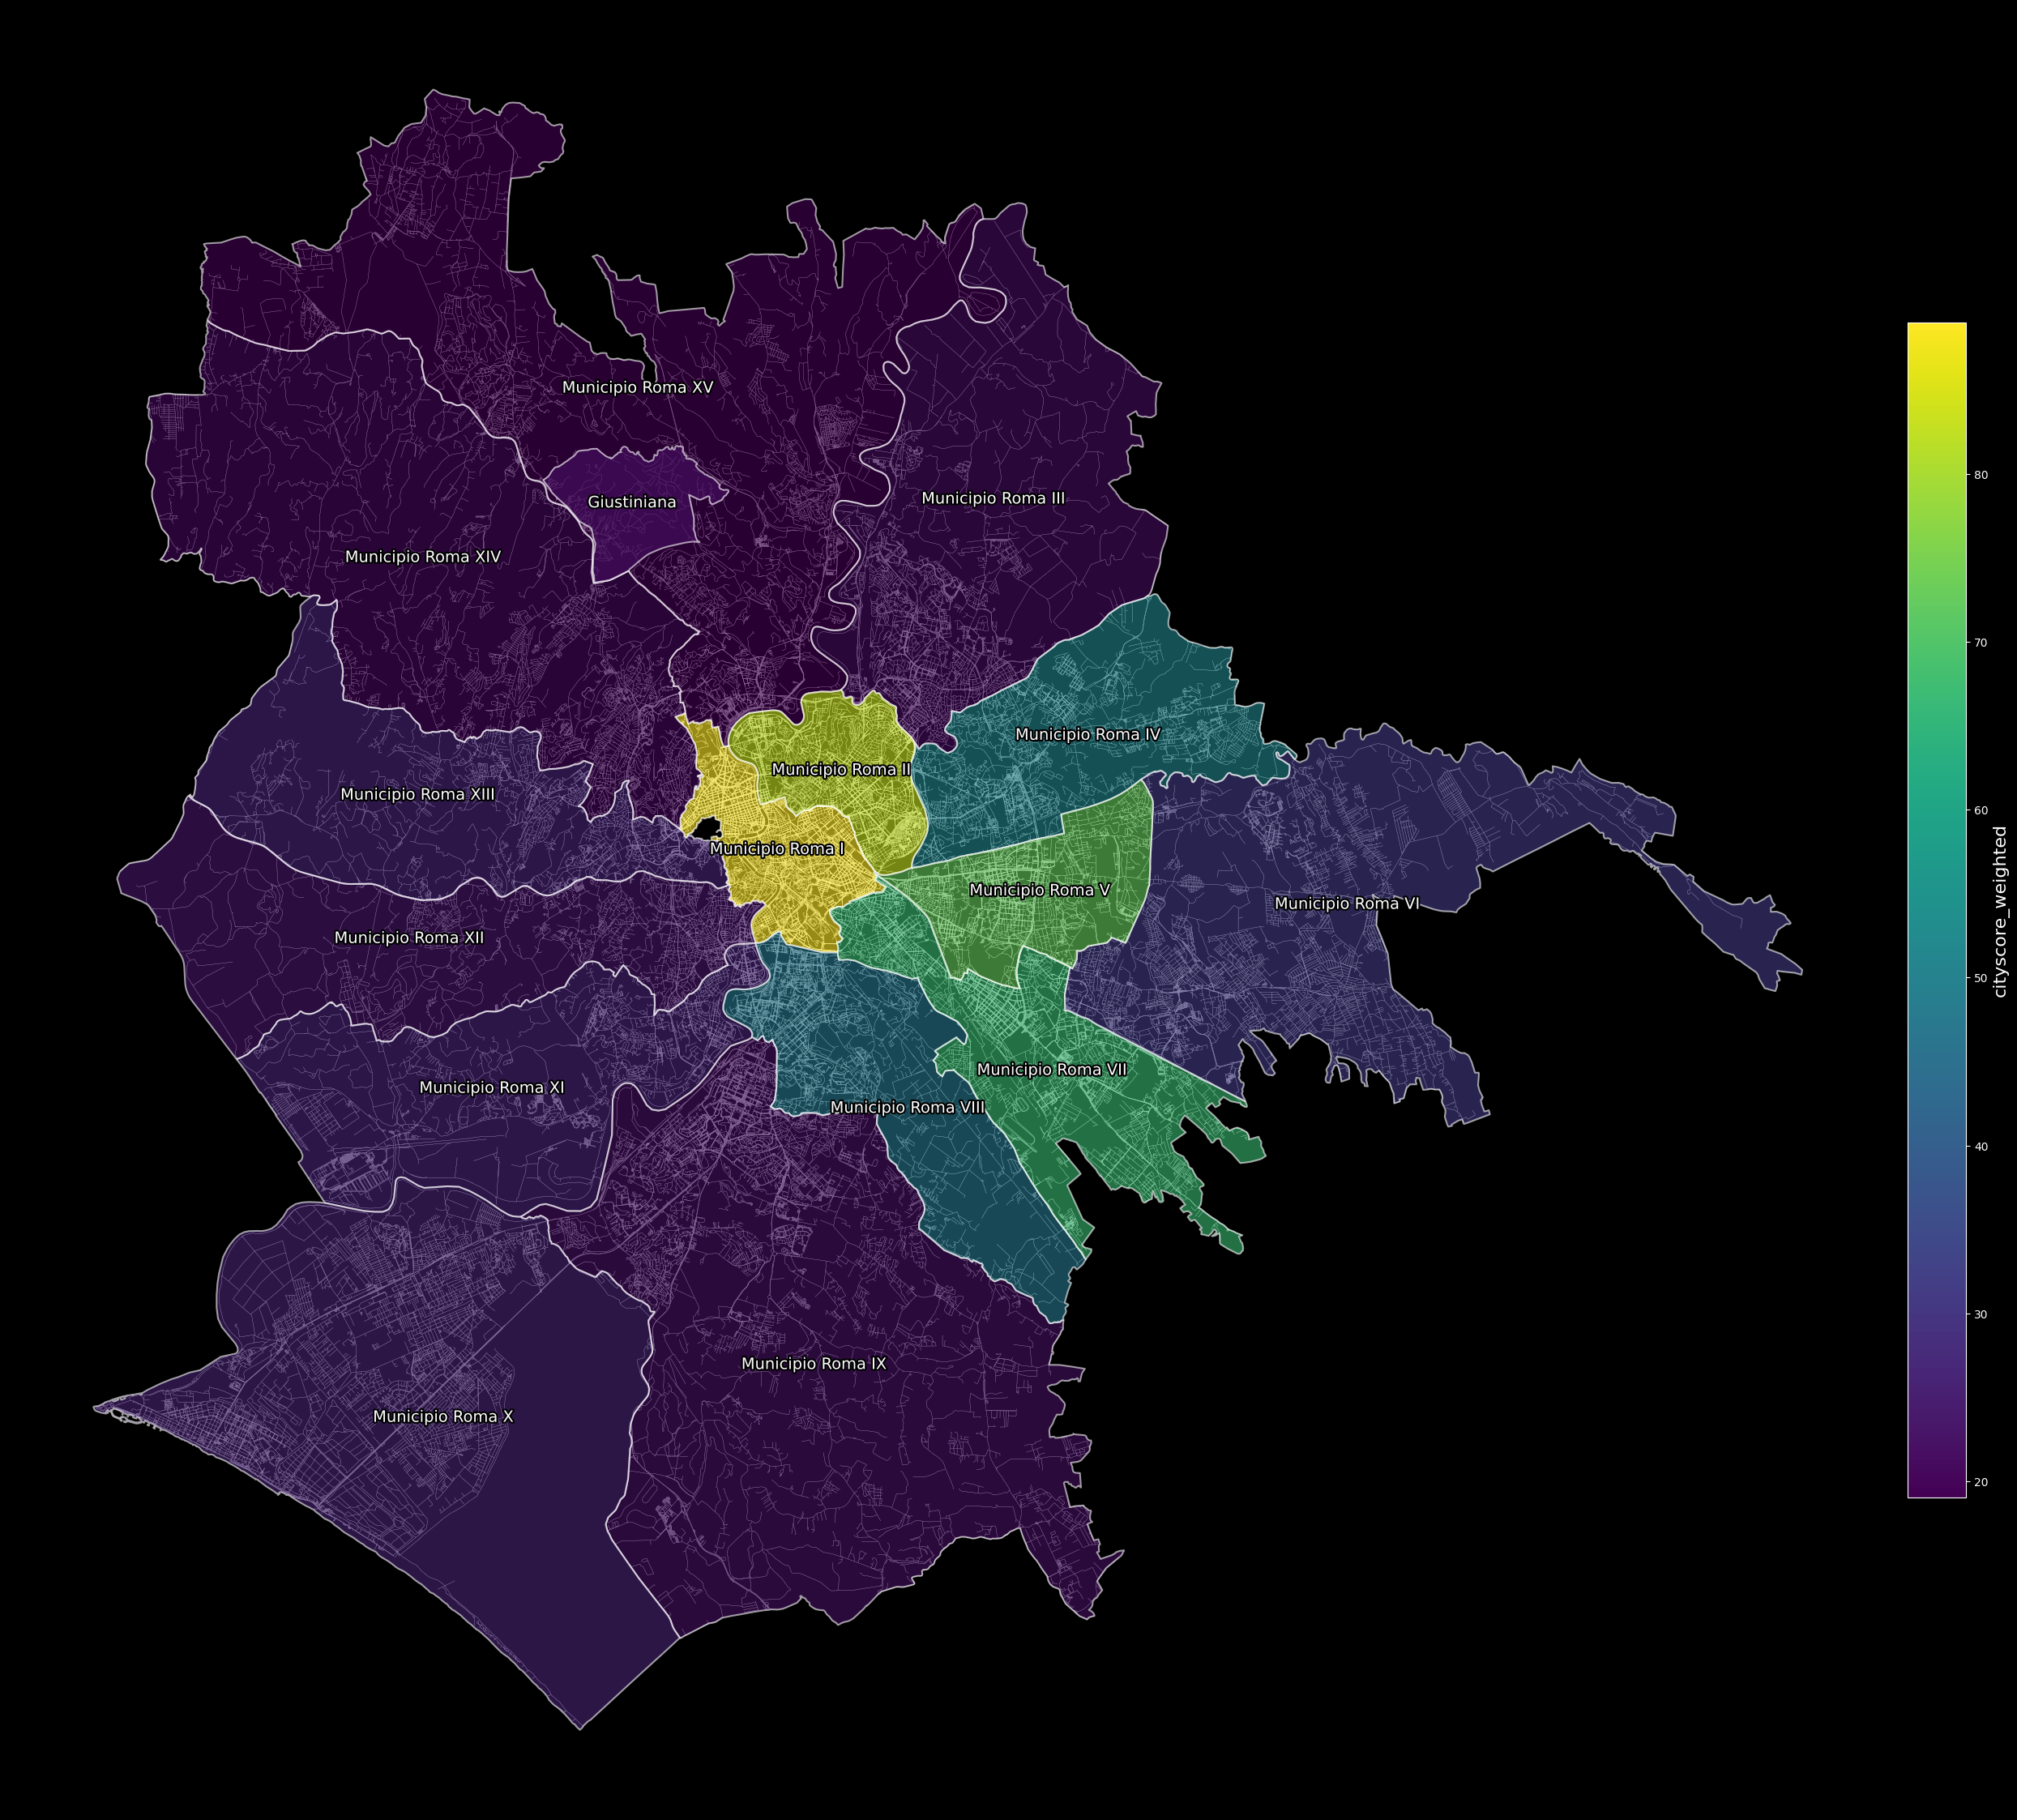

In [47]:
AOIM = AOIM.to_crs(25833)


# Normalize colormap per cityscore
norm = mcolors.Normalize(
    vmin=AOIM['cityscore_weighted'].min(), 
    vmax=AOIM['cityscore_weighted'].max()
)
cmap = plt.cm.viridis

# Plot
fig, ax = plt.subplots(figsize=(25, 25))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor('black')

# Pedestrian network as first layer 
edges_s.plot(ax=ax, color='white', linewidth=0.2, zorder=1)

# AOIM (cityscore_weighted) with transparency
AOIM.plot(
    ax=ax,
    column='cityscore_weighted',
    cmap=cmap,
    edgecolor='white',
    linewidth=1.5,
    alpha=0.6,
    zorder=2
)

# Labels (municipalities centroids)
for idx, row in AOIM.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        row['name'],
        fontsize=14,
        color='white',
        ha='center',
        va='center',
        zorder=3,
        path_effects=[PathEffects.withStroke(linewidth=3, foreground='black')]
    )

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
cbar.set_label('cityscore_weighted', fontsize=16, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

plt.tight_layout()


# Save
#plt.savefig('../output/ranking_15min.png')

In [40]:
# Saving AOIM in municipi_final2 that now contains the following columns
print(AOIM['cityscore_weighted'])
print(AOIM['density_nodes_km2'])
#AOIM.to_file("../data/15min_d/municipi_final2.gpkg", layer='municipi', driver="GPKG")

0     89.012585
1     20.799773
2     26.580255
3     19.059606
4     23.684566
5     26.533409
6     22.251104
7     47.283643
8     67.084286
9     21.350018
10    51.032811
11    31.440775
12    72.798085
13    82.860335
14    22.021282
15    26.290441
Name: cityscore_weighted, dtype: float64
0     325.116045
1      33.117049
2      45.261276
3      31.879776
4      40.542031
5      54.028803
6      52.369868
7     100.011813
8     138.439167
9      46.522136
10     95.830404
11     52.569299
12    154.860567
13    252.361281
14     26.680763
15     49.147844
Name: density_nodes_km2, dtype: float64
